<center>
<h1>MU4PY115 - IA pour la physique</h1>
<h1>TP n°2 : Régression linéaire</h1>
</center>

<br>

## Introduction

<br>

Dans ce notebook vous allez réaliser quelques expériences numériques avec la méthode de régression linéaire et étudier 2 méthodes de régularisation qui lui sont couramment associées appelées *régression ridge* et *régression lasso*.

<br>

In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["font.size"] = 16

<br>

## Régression linéaire par la méthode des moindres carrés

<br>

### Données 1D linéaires

Dans cette première partie vous allez utilisez la méthode de régression linéaire ordinaire pour déterminer les coefficients d'un modèle linéaire que l'on peut ajuster sur des données 1D générées artificiellement à partir d'une fonction linéaire bruitée (avec un bruit de type gaussien). 

<br>

**Génération des données**

- Créez une fonction permettant de générer un ensemble de $N$ données aléatoire $(x,y) \in \mathbb{R}^2$ telles que $x$ est tiré uniformément entre 0 et 1 et $y$ est de la forme
$$ y = ax + b + \varepsilon $$
où $a$ et $b$ sont des contantes réelles et $\varepsilon$ est une variable aléatoire gaussienne de moyenne nulle et de variance $\sigma^2$.

- Représentez un ensemble de données sur un graphe pour $N = 30$.

In [110]:
# fonction génératrice des données
def create_data(a, b, sigma, N):
    X = np.random.rand(N)
    epsilon = np.random.normal(0,sigma, size=N)
    y = a*X + b + epsilon
    return X,y

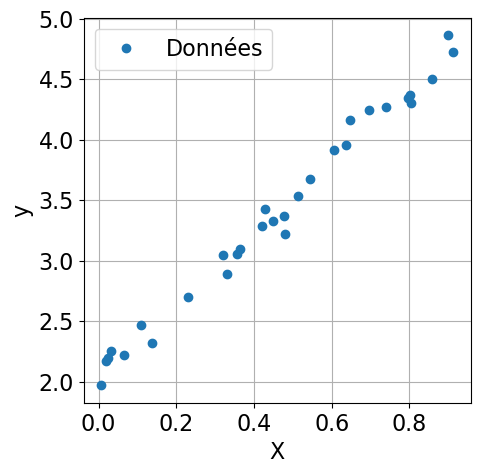

In [111]:
N = 30
a = 3
b = 2
sigma = 0.1

X,y = create_data(a, b, sigma, N)
plt.plot(X,y,'o', label='Données')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

<br>

**Régression linéaire ordinaire sur les données artificielles**

- A l'aide des formules établies en cours, créez un vecteur $w$ dont les composantes sont les coefficients du modèle linéaire que l'on peut ajuster sur ces données. Pour inverser une matrice, utilisez la fonction <code>numpy.linalg.inv()</code>. Pour la multiplication matricielle vous pouvez utilisez la fonction <code>numpy.matmul()</code> où l'opérateur @.

- Affichez à l'écran la valeurs des coefficients du modèle et représentez sur un graphe les données ainsi que le modèle linéaire obtenu.

In [112]:
w = np.ones(2)
X = np.vstack((np.ones(N), X)).T
print(X)

[[1.         0.80435894]
 [1.         0.51307889]
 [1.         0.54426802]
 [1.         0.6956264 ]
 [1.         0.02477267]
 [1.         0.36493441]
 [1.         0.32066843]
 [1.         0.03278848]
 [1.         0.42062776]
 [1.         0.74099771]
 [1.         0.63551364]
 [1.         0.48006967]
 [1.         0.44800965]
 [1.         0.06442307]
 [1.         0.80159273]
 [1.         0.32969401]
 [1.         0.85710053]
 [1.         0.01851919]
 [1.         0.22896919]
 [1.         0.42905777]
 [1.         0.13676258]
 [1.         0.89966992]
 [1.         0.35645814]
 [1.         0.64755928]
 [1.         0.00656302]
 [1.         0.10824905]
 [1.         0.91323764]
 [1.         0.60578526]
 [1.         0.47623393]
 [1.         0.79674469]]


[2.04457586 2.95947275]


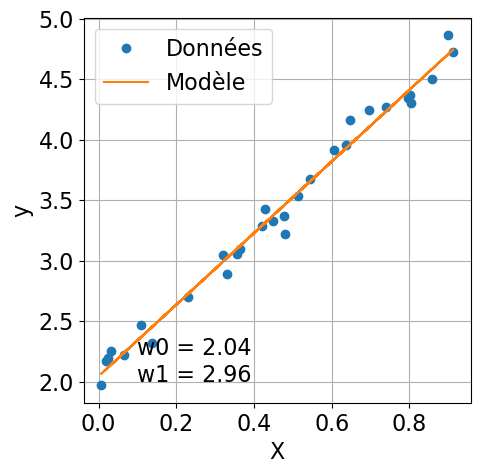

In [113]:
w = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)

print(w)
# plot data
plt.plot(X[:,1],y,'o', label='Données')
plt.plot(X[:,1], np.matmul(X,w), label='Modèle')
# show w values
plt.text(0.1, 2, 'w0 = {:.2f}\nw1 = {:.2f}'.format(w[0],w[1]))
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

<br>

**Régression linéaire avec scikit-learn**

- Vérifiez que vous obtenez bien le même résultat en utilisant la méthode <code>LinearRegression()</code> de la bibliothèque scikit-learn. Les coefficients du modèle correspondent aux attributs <code>.coef_</code> et <code>.intercept_</code>.


In [114]:
from sklearn.linear_model import LinearRegression

# create model
model = LinearRegression()
# fit model
model.fit(X,y)
# get model coefficients
w = np.array([model.intercept_, model.coef_[1]])
print(w)

[2.04457586 2.95947275]


<br>

**Incertitude sur l'estimation des coefficients**

Si $w$ représente le vecteur des coefficients d'un modèle linéaire, l'erreur standard sur l'estimation de la composante $w_j$ est donnée par 
$$ \sigma(w^*_j) \;=\; \sigma \, \sqrt{\Sigma^{-1}_{jj}} $$
où $\sigma$ représente l'incertitude, supposée uniforme, sur les données $y$, et $\Sigma = X^TX$ avec $X$ la matrice $n \times d$ des données d'entrée.

<br>

Estimez l'incertitude sur les coefficients que vous avez obtenus et comparez avec le résultat renvoyé par la fonction <code>scipy.stats.linregress()</code>.

In [115]:
sigma_data = np.ones(2)

sum = np.matmul(X.T,X)
sigma_w = sigma * np.sqrt(np.linalg.inv(sum)[1,1])
print(sigma_w)

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(X[:,1],y)
print(std_err)

0.06446403135665213
0.06524036676535548


<br>

### Application à des données réelles

<br>

Les données que vous allez utiliser sont issues d'une étude réalisée en 1989 sur 96 patients atteints d'un caner de la prostate. L'objectif de l'étude était de relier la quantité d'antigènes *prostate-specific* à différents paramètres physiologiques. Ces données se trouvent dans le fichier *data.csv*. Elles sont organisées sous la forme d'un tableau à 10 colonnes. Les 8 premières colonnes correspondent aux descripteurs suivants:

1. *lcavol* : log of cancer volume
2. *lweight* : log of prostate weight
3. *age* : age
4. *lbph* : log of the amount of benign prostatic hyperplasia
5. *svi* : seminal vesicle invasion
6. *lcp* : log of capsular penetration
7. *gleason* : Gleason score
8. *pgg45* : percent of Gleason scores 4 and 5

La colonne 9 contient la variable à prédire *lpsa* (= log of prostate-specific antigen) et la colonne 10 contient une variable binaire 'T' ou 'F' indiquant si la donnée correspondante a été utilisée dans le jeu d'entraînement ('T') ou dans le jeu de test ('F').

<br>

- Pour récupérer les données dans ce fichier, utiliser la fonction <code>read_csv()</code> de la librairie <code>pandas</code>. 
- Affichez les informations relatives aux données à l'aide des fonctions <code>.info()</code> et <code>.describe()</code>.

In [116]:
import pandas as pd

data = pd.read_csv('data-TP2.csv')

# Split the single column into multiple columns using semicolon as the delimiter
new_columns = data['lcavol;lweight;age;lbph;svi;lcp;gleason;pgg45;lpsa;train'].str.split(';', expand=True)

# Rename the new columns as needed
new_columns.columns = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa', 'train']

# Now, you have a more usable DataFrame with separate columns
df = new_columns

df.info()
df.describe()
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data-TP2.csv'

<br>

**Préparation des données: partitionnement et standardisation**

- Séparez les données en 1 jeu d'entraînement ($X_{train},y_{train}$) et 1 jeu de test ($X_{test},y_{test}$) en utilisant la variable fournie en colonne 10 pour sélectionner les données. 
- Vous pouvez convertir le dataframe pandas en tableau numpy à l'aide de l'attribut <code>.values</code>. Le tableau que vous aller obtenir contient des colonnes de nombre au format décimal et d'autres colonnes au format entier. Pour éviter d'éventuels problèmes liés à ces différents format lors du traitement des données, vous avez intérêt à convertir le tableau au format décimal à l'aide de la méthode <code>numpy.astype()</code>.
- Quel est le pourcentage des données initiales utilisées pour constituer le jeu d'entraînement ?

In [117]:
X_test = df[df['train'] == 'F'].values[:,:-2].astype(float)
y_test = df[df['train'] == 'F']['lpsa'].astype(float)

X_train = df[df['train'] == 'T'].values[:,:-2].astype(float)
y_train = df[df['train'] == 'T'].values[:,-2:-1].astype(float)

print(X_train.shape)
print(y_train.shape)
print('Pourcentage de données utilisées pour l\'entraînement: {:.2f}%'.format(100 * len(X_train) / len(df)))


(67, 8)
(67, 1)
Pourcentage de données utilisées pour l'entraînement: 69.07%


Avant d'utiliser un modèle pour ajuster un jeu de données, on effectue généralement une opération de **standardisation** sur les données. La standardisation la plus courante consiste à transformer les données de façon à ce que chaque descripteur ait une moyenne nulle et une variance égale à 1:

$$ x^{(i)}_j \; \; \rightarrow \; \; \frac{x^{(i)}_j - \bar{x_j}}{\sigma_j} $$

ATTENTION: les valeurs de $\bar{x_j}$ et $\sigma_j$ doivent être calculées pour les données d'entraînement uniquement ! En effet utiliser l'ensemble des données pour évaluer ces grandeurs signifie que l'on "contaminerait" le processus de traitement avec les données de test, ce qui risque de fausser l'évaluation finale du modèle.

- Effectuez cette transformation "manuellement" à l'aide de fonctions de la librairie <code>numpy</code>. Vérifiez que les données ont été correctement standardisées.
- Effectuez cette même transformation en utilisant la classe <code>StandardScaler</code> du module <code>sklearn.preprocessing</code> de scikit-learn.

In [118]:
X_train_stand = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_stand_sk = scaler.fit_transform(X_train)
X_test_stand_sk = scaler.fit_transform(X_test)

#compare the two results
print(np.allclose(X_train_stand, X_train_stand_sk))

X_train = np.copy(X_train_stand_sk)
X_test = np.copy(X_test_stand_sk)

True


<br>

**Modèle naïf**

Afin de juger de la qualité des modèles que l'on construit, il peut être utile de disposer d'une valeur de référence pour l'indicateur de performance utilisé. Pour cela on peut considérer un modèle très simple (parfois appelé *modèle naïf*) qui effectuerait des prédiction en prenant en compte uniquement les valeurs des étiquettes $y$. Dans le cas d'un problème de régression, on considère en général un modèle qui prédirait systématiquement la valeur moyenne des étiquettes.

- Calculez les étiquettes prédites par un tel modèle pour les données de test.
- En utilisant la fonction <code>mean_squared_error()</code> du module <code>sklearn.metrics</code> calculez le RMSE pour les données de test.

In [119]:
y_naif_predict = np.mean(y_train)
print(y_naif_predict)

from sklearn.metrics import mean_squared_error
# get RMSE for test data
print(y_test.shape)
mean_squared_error(y_test, np.ones(y_test.size)*y_naif_predict)

2.4523450850746267
(30,)


1.0567332280603818

<br>

**Régression linéaire ordinaire**

- Entraînez un modèle <code> LinearRegression()</code> avec les données d'entraînement.
- Calculez le score du modèle sur les données d'entraînement et sur les données de test à l'aide de la méthode <code>.score()</code>. A quelle grandeur correspond la valeur renvoyée ?
- Calculez le RMSE pour les données d'entraînement et de test.
- Représentez sur un graphique la valeur de l'étiquette prédite en fonction de l'étiquette vraie pour les données de test.
<br>


Score pour le test : 0.47395396934389833
Score pour le train: 0.6943711796768238
RMSE pour les données d'entrainements 0.662721486039448
RMSE pour les données de test 0.7430751535344677


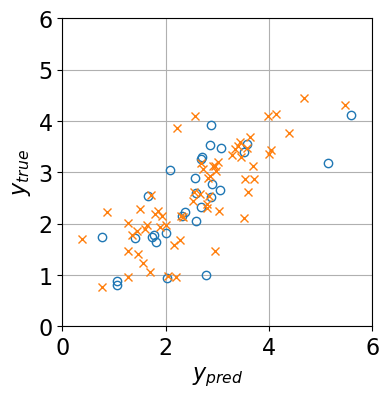

In [121]:
linreg = LinearRegression()

linreg.fit(X_train, y_train)

print(f"Score pour le test : {linreg.score(X_test,y_test)}")
print(f"Score pour le train: {linreg.score(X_train,y_train)}")

y_predict_train = linreg.predict(X_train)
y_predict_test = linreg.predict(X_test)

print(f"RMSE pour les données d'entrainements {np.sqrt(mean_squared_error(y_train, y_predict_train))}")
print(f"RMSE pour les données de test {np.sqrt(mean_squared_error(y_test, y_predict_test))}")

plt.figure(figsize=(4,4))
plt.plot(y_test, y_predict_test, 'o', fillstyle='none')
plt.plot(y_train, y_predict_train, 'x', fillstyle='none')
plt.xlim(0,6)
plt.ylim(0,6)
plt.xlabel(r'$y_{pred}$')
plt.ylabel(r'$y_{true}$')
plt.grid()

<br>

## Régularisation

<br>

La régression linéaire ordinaire ne permet pas de contrôler la compléxité du modèle, ce qui peut conduire à des problèmes de sur-apprentissage. La solution obtenue peut aussi être parfois instable, ce qui se traduit par le fait que de petites variations dans les données d'entraînement peuvent engendrer des variations importantes des coefficients du modèle. La méthode la plus courremment employée pour résoudre ces problèmes consiste à ajouter à la fonction de coût un terme pénalisant la complexité du modèle. Ce terme de pénalité sera le plus souvent de la forme
$$ J_{\ell_2}(w) \;=\; \|w\|^2_{\ell_2} \;=\; \sum_{j=1}^d \, w_j^2 \quad\rightarrow\quad \text{régression ridge}  $$
où
$$ J_{\ell_1}(w) \;=\; \|w\|_{\ell_1} \;=\; \sum_{j=1}^d \, |w_j| \quad\rightarrow\quad \text{régression lasso} $$

Les coefficients du modèle vont alors déterminés par minimisation de la fonction de coût pénalisée:
$$ R(w) \;=\; \sum_{i=1}^N \, \left( y_i - w_0 - \sum_{j=1}^d \, w_j\,x_j \right)^2 \;+\; \lambda \,J(w) $$

Le paramètre $\lambda$ permet de contrôler l'importance du terme de pénalité. Si on choisit $\lambda=0$ on va obtenir des coefficients $w_j$ correspondant à un modèle non pénalisé, donc potentiellement trop complexe. Au contraire, si on choisit une valeur très grande pour $\lambda$, les coefficients $w_j$ vont tendre vers 0, ce qui correspond dans la limite $\lambda \rightarrow \infty$ à un modèle constant. Le paramètre $\lambda$ permet donc de faire varier continuement la complexité du modèle.

<br>

### Régression *ridge*

<br>

- Pourquoi la standardisation des données est-elle très importante dans le cas d'une régression *ridge* ou *lasso* ?
- Entraînez un modèle *ridge* (module <code>sklearn.linear_model</code>) avec les données du dataset en fixant le paramètre de régularisation à une valeur très petite (10$^{-3}$) puis à une valeur élevée (10$^3$).
- Affichez la valeur des paramètres du modèle pour ces 2 cas ainsi que celles obtenues lors de la régression linéaire ordinaire. Commentez. Vers quelle valeur vont tendre les prédictions de la régression *ridge* lorsque le paramètre de régularisation a une valeur très élevée ?
- Entraînez à nouveau un modèle *ridge* sur ces données pour 50 valeurs du paramètre de régularisation comprises entre 10$^{-3}$ et 10$^3$. Calculez à chaque fois le RMSE pour les données d'entraînement et de test puis représentez sur un graphe l'évolution de ces grandeurs en fonction du paramètre de régularisation. Vous prendrez soin de mettre les abscisses en échelle logarithmique.
- Représentez l'évolution des coefficients du modèle en fonction de la valeur du paramètre de régularisation.

<br>


<br>

**Optimisation du paramètre de régularisation**

Le paramètre de régularisation optimal est généralement déterminé par la méthode de validation croisée associée à une recherche sur grille. La recherche sur grille consiste à définir un ensemble de valeurs pour un ou plusieurs méta-paramètres et à entraîner le modèle pour chaque combinaison possible de ces valeurs. Lorsque cette méthode est associée à une validation croisée, cela signifie que chaque modèle entraîné est évalué par validation croisée. Une fois la procédure terminée, on peut récupérer les valeurs des méta-paramètres ayant obtenue le meilleur score de validation.

<br>

Dans le cas de la régression *ridge* la recherche sur grille avec validation croisée est directement implémentée dans la classe <code>ridgeCV()</code> du module <code>sklearn.linear_model</code>. 

- Déterminez la valeur optimale du paramètre de régularisation à l'aide d'une validation croisée à 10 groupes en utilisant la fonction <code>RidgeCV()</code>.
- L'erreur obtenue sur le jeu de test est-elle plus grande ou plus petite que celle obtenue sur les jeux de validation ?

<br>


<br>

### Régression Lasso

<br>

Alors que la régression *ridge* pénalise la norme $\ell_2$ du vecteur des coefficients, la régression *lasso* pénalise la norme $\ell_1$. Nous allons comparer ici le résutat fourni par une régression *lasso* avec celui obtenu dans la section précédente avec la régression *ridge*.

- En utilisant une régression *lasso* déterminez l'erreur d'entraînement et l'erreur de test pour une série de valeurs du paramètre de régularisation (30 valeurs entre 1E-4 et 1E3). 
- Représentez sur un graphe l'évolution de ces erreurs en fonction de ce paramètre.
- Représentez sur un graphe l'évolution des coefficients du modèle en fonction de $\lambda$.
- Pour différentes valeurs du paramètre de régularisation, affichez la valeur des coefficients obtenus par une régression ridge et par une régression lasso. Que remarquez-vous ?
- Quelle est la spécificité de la régression lasso ? Quel intérêt cela peut-il présenter ?


<br> 

## Complément

<br>

### Augmentation de la dimension de l'espace d'entrée

<br>

Les méthodes utilisées dans les parties précédentes peuvent sembler assez limitées car les données que l'on doit analyser sont rarement linéaires. Nous allons montrer ici qu'en augmentant la dimension de l'espace d'entrée il est possible de produire un modèle non linéaire tout en continuant à appliquer une régression linéaire ordinaire, ridge ou lasso.

Un modèle linéaire en dimension $d$ s'écrit

$$ f(x) \;=\; w_0 \;+\; w_1\,x_1 \;+\; w_2\,x_2 \;+\; \dots \;+\; w_d\,x_d $$

où $x_j$ est la $j$-ième composante de $x \in \mathbb{R}^d$.

Dans le cas d'une variable $x \in \mathbb{R}$ on a simplement $f(x) = w_0 + w_1\,x$. Supposons maintenant que l'on crée une variable $z = [x, x^2, x^3, \dots, x^d]^T$. Un modèle linéaire par rapport à la variable $z \in \mathbb{R}^d$ sera alors de la forme

$$ f(z) \;=\; w_0 \;+\; w_1\,z_1 \;+\; w_2\,z_2 \;+\; \dots \;+\; w_d\,z_d $$

soit:

$$ f(x) \;=\; w_0 \;+\; w_1\,x \;+\; w_2\,x^2 \;+\; \dots \;+\; w_d\,x^d $$

c'est à dire un modèle polynomial de degré $d$ par rapport à la variable $x \in \mathbb{R}$.

<br>

Vous allez maintenant appliquer ce principe pour effectuer un ajustement polynomial sur des données 1D issues d'une fonction sinusoïdale.

<br>

**Génération des données**

- Créez une fonction qui génère $N$ données aléatoirement dans l'intervalle $[0,2\pi]$ telles que
$$ y = \sin(x) + \varepsilon $$
où $\varepsilon$ est une variable aléatoire gaussienne de moyenne nulle et variance $\sigma^2$.

- Représentez les données sur un graphe pour $N = 20$.


<br>

**Ajustement polynomial**

- Créez une fonction transformant le vecteur $x=[x^{(1)},\dots,x^{(N)}]^T$ en une matrice $X$ dont la ligne $i$ est $[x^{(i)},(x^{(i)})^2,\dots,(x^{(i)})^d]$, où $d$ est passé en argument lors de l'appel de la fonction. Vous pouvez obtenir le même résultat en utilisant la fonction <code>sklearn.preprocessing.PolynomialFeatures()</code>.

- Pour $d$ = 1 à 9, effectuez une régression linéaire ordinaire sur les données transformées

- Pour chacun de ces modèles, calculez les valeurs de $y$ pour 100 valeurs de $x$ régulièrement réparties entre 0 et 1.

- Représentez sur une série de graphes, les données ainsi que le modèle obtenu.

- Que remarquez-vous ?


<br>

### Overfitting

<br>

Dans cette partie nous allons mettre en évidence la diminution de la performance de prédiction lorsque le modèle est en sur-apprentissage.

- Ecrire une fonction qui génére un ensemble de données (du même type que précédemment) et le sépare en 1 jeu d'apprentissage et 1 jeu de test.
- Ecrire une fonction qui, pour un jeu d'entraînement et un jeu de test donnés, entraîne un modèle polynomial de degré $d$ et calcule le RMSE pour les données d'entraînement et les données de test.
- Ecrire une fonction tirant successivement $M$ jeux de données et calcule le RMSE moyen (d'entraînement et de test) sur ces $M$ tirages, pour un ensemble de valeurs $d$.
- Représentez sur un graphe l'évolution des RMSE moyens en fonction de $d$ pour $d\in{1,…,10}$. Comment évoluent ces grandeurs lorsqu'on modifie le nombre de données ?
- Que peut-on en conclure ?

<br>

### Régularisation

- Générez un jeu de données sinusïdales à l'aide de la fonction que vous avez précédemment écrite puis construire la matrice $X$ correspondant à un dévelopement polynomial de degré 9.
- Standardisez les données de façon à ce que toutes les composantes de la variable d'entrée aient une moyenne nulle et une même variance (utilisez la fonction <code>sklearn.preprocessing.StandardScaler()</code>).
- Effectuez une régression ridge en optimisant le paramètre de régularisation par validation croisée avec recherche sur grille.
- Déterminez l'erreur d'entraînement et l'erreur de test du modèle ainsi obtenu.
- Afin de visualiser l'effet de la régularisation vous pouvez représenter sur une série de graphe les données d'entraînement ainsi que le modèle obtenu pour différentes valeurs du paramètre de régularisation.
